# Univariate stats feature selection

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

loan_df = pd.read_csv('data/loan_data.csv', parse_dates=[
                      'DATE_OF_BIRTH', 'DISBURSAL_DATE'], infer_datetime_format=True)
# If we run ProfileReport once with minimal=True, it will not compute correlations after that
# ProfileReport(loan_df, minimal=True)
# we are sampling down so it runs faster
report = ProfileReport(loan_df.sample(10000, random_state=42))
# save as html so the notebook displays more easily
report.to_file('loan_df1.html')

Summarize dataset:   0%|          | 0/56 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
loan_df.shape

(133154, 41)

In [3]:
for col in loan_df.columns:
    fraction_unique = loan_df[col].unique().shape[0] / loan_df.shape[0]
    if fraction_unique > 0.5:
        print(col)

UNIQUEID


In [4]:
loan_df.drop('UNIQUEID', axis=1, inplace=True)

In [5]:
# drop columns with too little variety
drop_cols = ['MOBILENO_AVL_FLAG']
pri_sec_cols = [c for c in loan_df.columns if c[:3] in ['PRI', 'SEC'] and c not in ['PRI_NO_ACCTS', 'PRI_OVERDUE_ACCTS']]
drop_cols.extend(pri_sec_cols)
loan_df.drop(columns=drop_cols, axis=1, inplace=True)

In [6]:
loan_df.shape

(133154, 26)

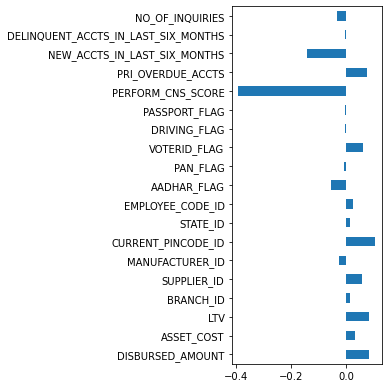

In [7]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(5.5, 5.5))
loan_df.corr().loc['LOAN_DEFAULT'][:-1].plot.barh()
plt.tight_layout()

In [8]:
from scipy.stats import pearsonr
from pandas.api.types import is_numeric_dtype

for c in loan_df.columns[:-1]:
    if is_numeric_dtype(loan_df[c]):
        correlation, pvalue = pearsonr(loan_df[c], loan_df['LOAN_DEFAULT'])            
        print(f'{c : <40}: {correlation : .4f}, significant: {pvalue <= 0.05}')

DISBURSED_AMOUNT                        :  0.0827, significant: True
ASSET_COST                              :  0.0322, significant: True
LTV                                     :  0.0834, significant: True
BRANCH_ID                               :  0.0129, significant: True
SUPPLIER_ID                             :  0.0572, significant: True
MANUFACTURER_ID                         : -0.0262, significant: True
CURRENT_PINCODE_ID                      :  0.1029, significant: True
STATE_ID                                :  0.0115, significant: True
EMPLOYEE_CODE_ID                        :  0.0235, significant: True
AADHAR_FLAG                             : -0.0565, significant: True
PAN_FLAG                                : -0.0083, significant: True
VOTERID_FLAG                            :  0.0592, significant: True
DRIVING_FLAG                            : -0.0035, significant: False
PASSPORT_FLAG                           : -0.0068, significant: True
PERFORM_CNS_SCORE                

In [9]:
loan_df.drop(columns=['DRIVING_FLAG', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'], axis=1, inplace=True)

In [10]:
report = ProfileReport(loan_df.sample(10000))
report.to_file('loan_df2.html')

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
import phik

In [12]:
loan_df_epoch_time = loan_df.copy()
loan_df_epoch_time['DATE_OF_BIRTH'] = (loan_df_epoch_time['DATE_OF_BIRTH'] - pd.to_datetime('1-1-1970')).dt.total_seconds()
loan_df_epoch_time['DISBURSAL_DATE'] = (loan_df_epoch_time['DISBURSAL_DATE'] - pd.to_datetime('1-1-1970')).dt.total_seconds()

interval_columns = ['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'DATE_OF_BIRTH', 'DISBURSAL_DATE', 'PERFORM_CNS_SCORE',
                   'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']

for c in loan_df_epoch_time.columns:
    if c not in interval_columns:
        loan_df_epoch_time[c] = loan_df_epoch_time[c].astype('category')

In [13]:
# WARNING: this takes a very long time to run
# loan_df_epoch_time.phik_matrix(interval_cols=interval_columns)

In [14]:
# this also takes a long time to run
# loan_df_epoch_time.significance_matrix(interval_cols=interval_columns)

In [15]:
phik_correlations = []
phik_significances = []
columns = loan_df_epoch_time.columns
y = loan_df_epoch_time['LOAN_DEFAULT']

for c in columns:
    x = loan_df_epoch_time[c]
    if c in interval_columns:
        phik_correlations.append(phik.phik_from_array(x, y, [c]))
        phik_significances.append(phik.significance.significance_from_array(x, y, [c])[0])
    else:
        phik_correlations.append(phik.phik_from_array(x, y))
        # currently need to set the drop over/underflow to false to avoid error. Should be fixed soon in an update
        phik_significances.append(phik.significance.significance_from_array(x, y, drop_overflow=False, drop_underflow=False)[0])

C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\phik\data_quality.py:112: UserWarning: The number of unique values of variable x is large: 2869. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\phik\data_quality.py:112: UserWarning: The number of unique values of variable x is large: 2869. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\phik\data_quality.py:112: UserWarning: The number of unique values of variable x is large: 6189. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\phik\data_quality.py:112: UserWarning: The number of unique values of variable x is large: 6189. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\words\Anaconda3\envs\datasc

In [16]:
phik_df = pd.DataFrame({'phik': phik_correlations, 'p-value': phik_significances}, index=columns)
phik_df.sort_values(by='phik', ascending=False, inplace=True)

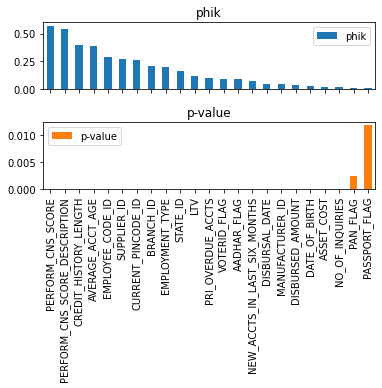

In [17]:
phik_df.iloc[1:].plot.bar(subplots=True, figsize=(5.5, 5.5))
plt.tight_layout()

In [18]:
phik_df

,phik,p-value
LOAN_DEFAULT,1.000000,0.000000e+00
PERFORM_CNS_SCORE,0.571959,0.000000e+00
PERFORM_CNS_SCORE_DESCRIPTION,0.541453,0.000000e+00
CREDIT_HISTORY_LENGTH,0.397205,0.000000e+00
AVERAGE_ACCT_AGE,0.391147,0.000000e+00
EMPLOYEE_CODE_ID,0.285944,0.000000e+00
SUPPLIER_ID,0.268258,0.000000e+00
CURRENT_PINCODE_ID,0.263181,0.000000e+00
BRANCH_ID,0.205041,0.000000e+00
EMPLOYMENT_TYPE,0.201645,0.000000e+00


# Mutual information score and chi-squared

In [19]:
from sklearn.metrics import normalized_mutual_info_score

loan_df.corr(method=normalized_mutual_info_score)

,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,STATE_ID,EMPLOYEE_CODE_ID,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PRI_OVERDUE_ACCTS,NEW_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT
DISBURSED_AMOUNT,1.000000,0.672905,0.533719,0.253136,0.481720,0.090964,0.516901,0.157499,0.521523,0.023587,1.578066e-02,0.022188,1.590661e-03,0.214469,0.023639,0.037129,0.027676,0.022441
ASSET_COST,0.672905,1.000000,0.716856,0.443739,0.700192,0.175233,0.693323,0.289881,0.719801,0.039380,2.599484e-02,0.037168,2.007877e-03,0.307866,0.037202,0.061842,0.044234,0.034935
LTV,0.533719,0.716856,1.000000,0.189871,0.492414,0.056161,0.534091,0.090602,0.537294,0.008447,6.104969e-03,0.008100,1.365189e-03,0.206412,0.014042,0.022028,0.017005,0.008049
BRANCH_ID,0.253136,0.443739,0.189871,1.000000,0.701821,0.064777,0.652846,0.755495,0.677916,0.071556,3.037022e-02,0.063769,6.593821e-04,0.053100,0.005001,0.010744,0.008039,0.005744
SUPPLIER_ID,0.481720,0.700192,0.492414,0.701821,1.000000,0.323717,0.712319,0.517890,0.850592,0.048490,2.820681e-02,0.043372,1.264320e-03,0.169602,0.011984,0.019655,0.016326,0.008729
MANUFACTURER_ID,0.090964,0.175233,0.056161,0.064777,0.323717,1.000000,0.085878,0.051946,0.180986,0.005493,3.193152e-03,0.005016,2.459346e-04,0.009500,0.001268,0.002105,0.001610,0.000612
CURRENT_PINCODE_ID,0.516901,0.693323,0.534091,0.652846,0.712319,0.085878,1.000000,0.492527,0.729889,0.046726,2.320907e-02,0.042112,1.410693e-03,0.202391,0.015738,0.026624,0.020378,0.011285
STATE_ID,0.157499,0.289881,0.090602,0.755495,0.517890,0.051946,0.492527,1.000000,0.488975,0.097543,3.884043e-02,0.086094,3.882704e-04,0.030141,0.005389,0.011247,0.008089,0.005396
EMPLOYEE_CODE_ID,0.521523,0.719801,0.537294,0.677916,0.850592,0.180986,0.729889,0.488975,1.000000,0.047899,3.085719e-02,0.043104,1.498260e-03,0.198448,0.013356,0.022283,0.018232,0.009203
AADHAR_FLAG,0.023587,0.039380,0.008447,0.071556,0.048490,0.005493,0.046726,0.097543,0.047899,1.000000,4.423808e-02,0.689471,1.083035e-02,0.003495,0.000936,0.004201,0.004158,0.002909


In [20]:
loan_df_epoch_time['EMPLOYMENT_TYPE'] = loan_df_epoch_time['EMPLOYMENT_TYPE'].astype('category')

In [21]:
from sklearn.feature_selection import mutual_info_classif

numeric_features = loan_df.select_dtypes(include=['number']).copy()
numeric_features.drop('LOAN_DEFAULT', axis=1, inplace=True)
list(zip(numeric_features.columns, mutual_info_classif(numeric_features, loan_df['LOAN_DEFAULT'])))

[('DISBURSED_AMOUNT', 0.00818802562686849),
 ('ASSET_COST', 0.007926959787164511),
 ('LTV', 0.010061745087821539),
 ('BRANCH_ID', 0.014021439210180509),
 ('SUPPLIER_ID', 0.022572684395657294),
 ('MANUFACTURER_ID', 0.006790207432869622),
 ('CURRENT_PINCODE_ID', 0.022244919980581646),
 ('STATE_ID', 0.008577911525640358),
 ('EMPLOYEE_CODE_ID', 0.02518303576179992),
 ('AADHAR_FLAG', 0.016287988402544418),
 ('PAN_FLAG', 0.0),
 ('VOTERID_FLAG', 0.003965252018808707),
 ('PASSPORT_FLAG', 0.0006495101398427128),
 ('PERFORM_CNS_SCORE', 0.11059829825933143),
 ('PRI_OVERDUE_ACCTS', 0.0035034353719212152),
 ('NEW_ACCTS_IN_LAST_SIX_MONTHS', 0.015548876803417322),
 ('NO_OF_INQUIRIES', 0.0026642377675822893)]

In [22]:
from sklearn.feature_selection import chi2

chi2(loan_df[['PAN_FLAG', 'STATE_ID']], loan_df['LOAN_DEFAULT'])

(array([ 8.46807323, 48.3495596 ]), array([3.61434074e-03, 3.56624293e-12]))

In [23]:
from sklearn.feature_selection import f_classif

f_classif(loan_df[['PERFORM_CNS_SCORE', 'PAN_FLAG', 'STATE_ID']], loan_df['LOAN_DEFAULT'])

(array([2.41525739e+04, 9.15861992e+00, 1.74974209e+01]),
 array([0.00000000e+00, 2.47596457e-03, 2.87881660e-05]))

In [24]:
from sklearn.feature_selection import SelectKBest

x = SelectKBest(f_classif, k=5).fit_transform(loan_df_epoch_time[interval_columns], loan_df_epoch_time['LOAN_DEFAULT'])
x.shape

(133154, 5)

# Feature engineering

In [25]:
import re
# prototype regex
re.search(r'(\d+)yrs\s+(\d+)mon', '1yrs 11mon').groups()

('1', '11')

In [26]:
def convert_date_spans(x):
    """
    Parses date spans of the form "1yrs 1mon"
    into the number of months as an integer.
    """
    yrs, mon = re.search(r'(\d+)yrs\s+(\d+)mon', x).groups()
    yrs, mon = int(yrs), int(mon)
    months = yrs * 12 + mon
    return months

In [27]:
import swifter

loan_df['AVERAGE_ACCT_AGE_MONTHS'] = loan_df.swifter.apply(lambda x: convert_date_spans(x['AVERAGE_ACCT_AGE']), axis=1)
loan_df['CREDIT_HISTORY_LENGTH_MONTHS'] = loan_df.swifter.apply(lambda x: convert_date_spans(x['CREDIT_HISTORY_LENGTH']),
                                                      axis=1)
loan_df.drop(['AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH'], axis=1, inplace=True)

Pandas Apply:   0%|          | 0/133154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/133154 [00:00<?, ?it/s]

<AxesSubplot:>

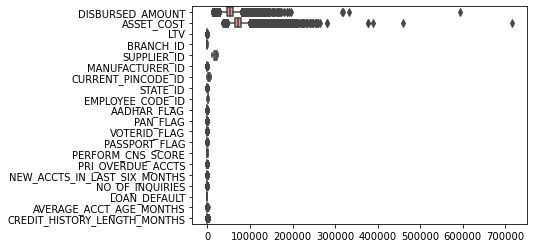

In [28]:
import seaborn as sns

sns.boxplot(data=loan_df, orient='h')

<AxesSubplot:>

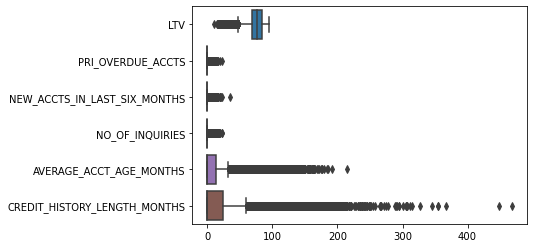

In [29]:
dropcols = ['DISBURSED_AMOUNT', 'ASSET_COST', 'PERFORM_CNS_SCORE', 'LOAN_DEFAULT'] + \
            [c for c in loan_df.columns if 'ID' in c or 'FLAG' in c]
sns.boxplot(data=loan_df.drop(dropcols, axis=1), orient='h')

<AxesSubplot:>

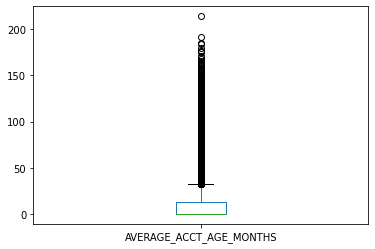

In [30]:
loan_df['AVERAGE_ACCT_AGE_MONTHS'].plot.box()

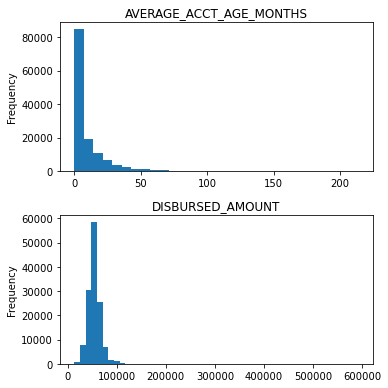

In [31]:
f, ax = plt.subplots(2, 1, figsize=(5.5, 5.5))
loan_df['AVERAGE_ACCT_AGE_MONTHS'].plot.hist(bins=30, ax=ax[0], title='AVERAGE_ACCT_AGE_MONTHS')
loan_df['DISBURSED_AMOUNT'].plot.hist(bins=50, ax=ax[1], title='DISBURSED_AMOUNT')
plt.tight_layout()

<AxesSubplot:ylabel='Frequency'>

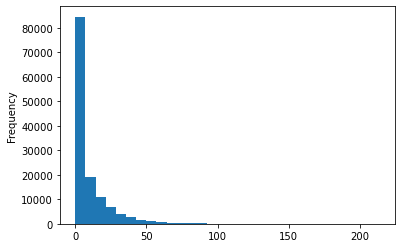

In [32]:
loan_df['AVERAGE_ACCT_AGE_MONTHS'].plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

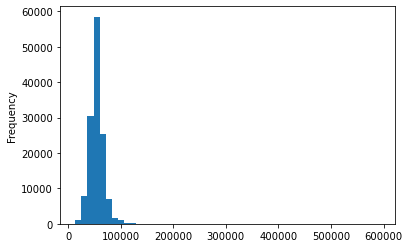

In [33]:
loan_df['DISBURSED_AMOUNT'].plot.hist(bins=50)

In [34]:
import numpy as np

q3 = loan_df['DISBURSED_AMOUNT'].quantile(0.75)
q1 = loan_df['DISBURSED_AMOUNT'].quantile(0.25)
iqr = (q3 - q1)
outliers = np.where(loan_df['DISBURSED_AMOUNT'] > (q3 + 1.5 * iqr))[0]
1.5 * iqr + q3

80400.0

In [35]:
loan_df['DISBURSED_AMOUNT'][outliers]

21         93799
107        91355
131        96190
149       112463
166        84023
           ...  
132840     93000
132887     93520
132924     82033
133007     97899
133122     85243
Name: DISBURSED_AMOUNT, Length: 4127, dtype: int64

In [36]:
loan_df['DISBURSED_AMOUNT'].clip(upper=1.5 * iqr + q3)

0         48349
1         55159
2         67882
3         55613
4         46249
          ...  
133149    63213
133150    48549
133151    62613
133152    48803
133153    52003
Name: DISBURSED_AMOUNT, Length: 133154, dtype: int64

In [37]:
loan_df['DISBURSED_AMOUNT'].clip(upper=1.5 * iqr + q3)[outliers]

21        80400
107       80400
131       80400
149       80400
166       80400
          ...  
132840    80400
132887    80400
132924    80400
133007    80400
133122    80400
Name: DISBURSED_AMOUNT, Length: 4127, dtype: int64

## Combining multiple columns

In [38]:
(loan_df['DISBURSAL_DATE'] - loan_df['DATE_OF_BIRTH']).dt.days

0         13463
1         15634
2          9702
3          7917
4         14124
          ...  
133149    14085
133150     8144
133151    10521
133152    12152
133153    16312
Length: 133154, dtype: int64

In [39]:
loan_df['AGE'] = (loan_df['DISBURSAL_DATE'] - loan_df['DATE_OF_BIRTH']) // 365

In [40]:
(loan_df['DISBURSAL_DATE'] - loan_df['DATE_OF_BIRTH']).dt.days

0         13463
1         15634
2          9702
3          7917
4         14124
          ...  
133149    14085
133150     8144
133151    10521
133152    12152
133153    16312
Length: 133154, dtype: int64

In [41]:
from dateutil import relativedelta

# this method of calculating age is more precise
def calculate_age_in_years(x):
    return relativedelta.relativedelta(x['DISBURSAL_DATE'], x['DATE_OF_BIRTH']).years
    
loan_df['AGE'] = loan_df.swifter.apply(lambda x: calculate_age_in_years(x), axis=1)

Pandas Apply:   0%|          | 0/133154 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Frequency'>

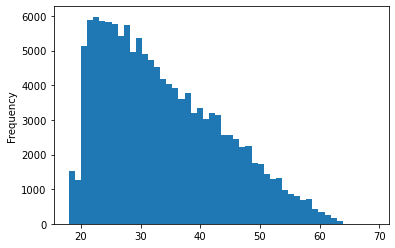

In [42]:
loan_df['AGE'].plot.hist(bins=50)

# Transforming numeric data
## Standardization

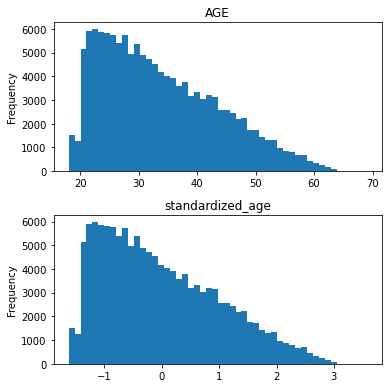

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
loan_df['standardized_age'] = scaler.fit_transform(loan_df['AGE'].values.reshape(-1, 1))

f, ax = plt.subplots(2, 1, figsize=(5.5, 5.5))
loan_df['AGE'].plot.hist(ax=ax[0], title='AGE', bins=50)
loan_df['standardized_age'].plot.hist(ax=ax[1], title='standardized_age', bins=50)
plt.tight_layout()

In [44]:
loan_df['standardized_age'].describe()

count    1.331540e+05
mean    -5.176160e-17
std      1.000004e+00
min     -1.623361e+00
25%     -8.085419e-01
50%     -1.974278e-01
75%      7.192434e-01
max      3.571109e+00
Name: standardized_age, dtype: float64

## Box-cox and Yeo-Johnson transforms

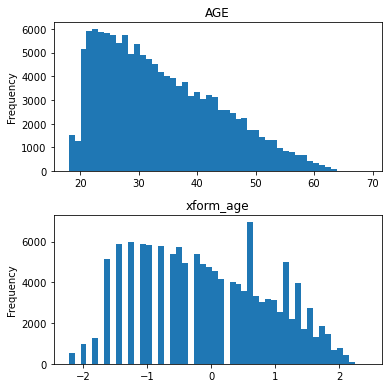

In [45]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()

loan_df['xform_age'] = pt.fit_transform(loan_df['AGE'].values.reshape(-1, 1))

f, ax = plt.subplots(2, 1, figsize=(5.5, 5.5))
loan_df['AGE'].plot.hist(ax=ax[0], title='AGE', bins=50)
loan_df['xform_age'].plot.hist(ax=ax[1], title='xform_age', bins=50)
plt.tight_layout()

In [46]:
pt.transform(loan_df['AGE'].values.reshape(-1, 1))

array([[ 0.3856874 ],
       [ 0.90523825],
       [-0.78502857],
       ...,
       [-0.50945023],
       [ 0.08259266],
       [ 1.05772199]])

In [47]:
import pickle as pk

with open('age_pt.pk', 'wb') as f:
    pk.dump(pt, f)

# Extracting datetime features

In [48]:
loan_df['DISBURSAL_DATE'].dt.dayofweek

0         1
1         6
2         3
3         2
4         2
         ..
133149    4
133150    4
133151    0
133152    2
133153    3
Name: DISBURSAL_DATE, Length: 133154, dtype: int64

# Binning

In [49]:
from sklearn.preprocessing import KBinsDiscretizer

kbd = KBinsDiscretizer(n_bins=10, encode='ordinal')
loan_df['binned_disbursed_amount'] = kbd.fit_transform(loan_df['DISBURSED_AMOUNT'].values.reshape(-1, 1)).astype('int')
loan_df['binned_disbursed_amount']

0         2
1         5
2         8
3         5
4         2
         ..
133149    8
133150    2
133151    8
133152    3
133153    4
Name: binned_disbursed_amount, Length: 133154, dtype: int32

# One-hot encoding and label encoding

In [50]:
loan_df['EMPLOYMENT_TYPE'].fillna('Self employed', inplace=True)
# double-check to make sure we only have 2 unique values
loan_df['EMPLOYMENT_TYPE'].unique()

array(['Salaried', 'Self employed'], dtype=object)

In [51]:
loan_df['EMPLOYMENT_TYPE'] = loan_df['EMPLOYMENT_TYPE'].map(lambda x: 1 if x == 'Self employed' else 0)
# convert from object to int dtype
loan_df['EMPLOYMENT_TYPE'] = loan_df['EMPLOYMENT_TYPE'].astype('int')
loan_df['EMPLOYMENT_TYPE'].unique()

array([0, 1])

In [52]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
loan_df['le_branch_id'] = le.fit_transform(loan_df['BRANCH_ID'])
loan_df['le_branch_id']

0          2
1         34
2          4
3         47
4         30
          ..
133149    56
133150     1
133151     2
133152    24
133153     1
Name: le_branch_id, Length: 133154, dtype: int64

In [53]:
loan_df['BRANCH_ID'].unique().shape

(82,)

In [54]:
loan_df['le_branch_id'].max()

81

### Simplifying categorical columns

In [55]:
(loan_df['MANUFACTURER_ID'].value_counts().cumsum() / loan_df.shape[0])[:20]

86     0.469434
45     0.712679
51     0.828297
48     0.900701
49     0.944493
120    0.985889
67     0.996523
145    0.999902
153    0.999970
152    1.000000
Name: MANUFACTURER_ID, dtype: float64

### Simplifying categorical columns

In [56]:
loan_df['MANUFACTURER_ID'].value_counts()

86     62507
45     32389
51     15395
48      9641
49      5831
120     5512
67      1416
145      450
153        9
152        4
Name: MANUFACTURER_ID, dtype: int64

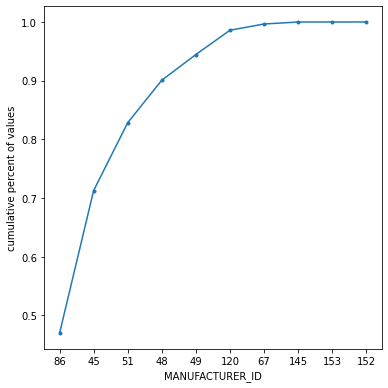

In [57]:
(loan_df['MANUFACTURER_ID'].value_counts().cumsum() / loan_df.shape[0]).reset_index(drop=True).plot(marker='.', figsize=(5.5, 5.5))
plt.xlabel('MANUFACTURER_ID')
plt.ylabel('cumulative percent of values')
plt.xticks(range(loan_df['MANUFACTURER_ID'].unique().shape[0]), loan_df['MANUFACTURER_ID'].value_counts().index)
plt.tight_layout()

In [58]:
# any manufacterer ids not in the top 6 are set to 'other'
loan_df.loc[~loan_df['MANUFACTURER_ID'].isin([86, 45, 51, 48, 49, 120]), 'MANUFACTURER_ID'] = 'other'
# could also do this way
loan_df.loc[loan_df['MANUFACTURER_ID'].isin([67, 145, 153, 152]), 'MANUFACTURER_ID'] = 'other'

In [59]:
manufacturer_ohe = pd.get_dummies(loan_df['MANUFACTURER_ID'],
                                    prefix='MANU_ID',
                                    prefix_sep='=').drop(['MANU_ID=other'], axis=1)
manufacturer_ohe

,MANU_ID=45,MANU_ID=48,MANU_ID=49,MANU_ID=51,MANU_ID=86,MANU_ID=120
0,0,0,0,1,0,0
1,1,0,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,0,1,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
133149,1,0,0,0,0,0
133150,0,0,1,0,0,0
133151,0,0,0,1,0,0
133152,1,0,0,0,0,0


In [60]:
loan_df_ohe = pd.concat([loan_df, manufacturer_ohe], axis=1)
loan_df_ohe

,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,...,standardized_age,xform_age,binned_disbursed_amount,le_branch_id,MANU_ID=45,MANU_ID=48,MANU_ID=49,MANU_ID=51,MANU_ID=86,MANU_ID=120
0,48349,65210,76.68,3,16092,51,51,1981-12-20,0,2018-10-30,...,0.209982,0.385687,2,2,0,0,0,1,0,0
1,55159,62972,88.93,72,16682,45,475,1976-01-01,1,2018-10-21,...,0.821096,0.905238,5,34,1,0,0,0,0,0
2,67882,113530,61.66,7,23091,51,5858,1992-03-26,1,2018-10-18,...,-0.808542,-0.785029,8,4,0,0,0,1,0,0
3,55613,69807,85.95,103,20285,86,6995,1997-01-01,1,2018-09-05,...,-1.317804,-1.609313,5,47,0,0,0,0,1,0
4,46249,67645,70.22,67,18129,45,1511,1980-02-22,0,2018-10-24,...,0.413686,0.570433,2,30,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133149,63213,75976,84.24,136,23672,45,3773,1980-04-03,1,2018-10-26,...,0.413686,0.570433,8,56,1,0,0,0,0,0
133150,48549,98000,50.20,2,24261,49,1670,1996-04-30,0,2018-08-17,...,-1.215951,-1.425946,2,1,0,0,1,0,0,0
133151,62613,71751,89.75,3,17339,51,551,1990-01-01,1,2018-10-22,...,-0.604837,-0.509450,8,2,0,0,0,1,0,0
133152,48803,60641,83.28,61,15919,45,1377,1985-05-22,1,2018-08-29,...,-0.095575,0.082593,3,24,1,0,0,0,0,0


# Dimensionality Reduction
## PCA

In [61]:
from sklearn.decomposition import PCA

ss = StandardScaler()
scaled = ss.fit_transform(loan_df_epoch_time[interval_columns])
pca = PCA(random_state=42)
loan_pca = pca.fit_transform(scaled)

In [62]:
loan_pca.shape

(133154, 8)

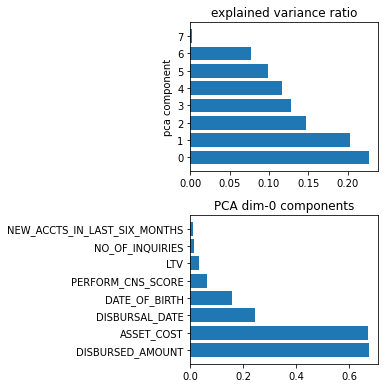

In [63]:
idx = pca.explained_variance_ratio_.argsort()[::-1]
ticks = range(pca.n_components_)
f, ax = plt.subplots(2, 1, figsize=(5.5, 5.5))

ax[0].barh(ticks, pca.explained_variance_ratio_[idx])
ax[0].set_title('explained variance ratio')
ax[0].set_ylabel('pca component')
ax[0].set_yticks(ticks)

comp_idx = abs(pca.components_[0]).argsort()[::-1]
ax[1].barh(ticks, abs(pca.components_[0, comp_idx]))
plt.yticks(ticks, np.array(interval_columns)[comp_idx])
ax[1].set_title('PCA dim-0 components')

plt.tight_layout()

Text(0.5, 0, 'pca component')

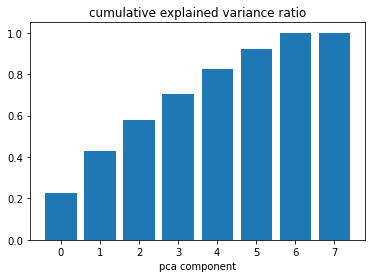

In [64]:
# we can look for an "elbow" in this plot. The only elbow is at component 7 (labeled "6" below).
# So we could throw out the last PCA dimension
plt.bar(ticks, pca.explained_variance_ratio_[idx].cumsum())
plt.title('cumulative explained variance ratio')
plt.xlabel('pca component')

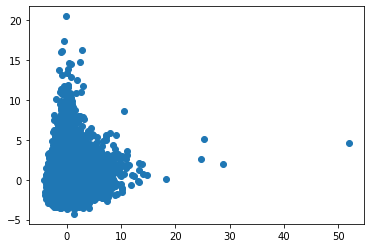

In [65]:
# when clustering data, we can plot the PCA dimensions to make it easier to visualize. More on this in chapter 16.
plt.scatter(loan_pca[:, 0], loan_pca[:, 1])